## GROUP N°

## NAMES 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import other libraries when needed 

## 1. DATA PROCESSING

In [2]:
# Load raw data
df = pd.read_parquet("dataDumper.parquet")

In [3]:
df.head()

,Time_utc,VehicleName,VehicleType,Pressure_Pa_1,Pressure_Pa_2,Pressure_Pa_3,Pressure_Pa_4,Pressure_Pa_5,Pressure_Pa_6,Temperature_K_1,...,Altitude_m,Speed_mps,epsilonX,epsilonY,epsilonZ,epsilonSpeed,AtmosphericPressure_Pa,dt_s,dd_m,RatioPayload
0,2023-01-01 00:00:00.328,C-132,Dumper,993010.933333,1.003995e+06,856000.0,798005.466667,819994.533333,864994.533333,346.15,...,4581.000000,9.003,6.207,6.312,23.000000,0.0,59002.557667,4.912,41.480140,0.0
1,2023-01-01 00:00:05.338,C-132,Dumper,993177.933329,1.003911e+06,856000.0,798088.966665,819911.033335,864911.033335,346.15,...,4577.600098,9.003,6.393,6.797,27.600000,0.0,59028.296172,5.010,45.952211,0.0
2,2023-01-01 00:00:10.331,C-132,Dumper,993344.366669,1.003828e+06,856000.0,798172.183334,819827.816666,864827.816666,346.15,...,4573.000000,9.723,6.721,7.631,32.200001,0.0,59064.789917,4.993,47.007842,0.0
3,2023-01-01 00:00:15.325,C-132,Dumper,993510.833331,1.003745e+06,856000.0,798255.416666,819744.583334,864744.583334,346.15,...,4568.600098,9.620,6.361,6.504,23.000000,0.0,59101.596928,4.994,48.700870,0.0
4,2023-01-01 00:00:20.448,C-132,Dumper,993681.600000,1.003659e+06,856000.0,798340.800000,819659.200000,864659.200000,346.15,...,4564.500000,11.318,6.361,7.144,23.000000,0.0,59139.354701,5.123,52.675397,0.0


In [4]:
df.columns

Index(['Time_utc', 'VehicleName', 'VehicleType', 'Pressure_Pa_1',
       'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5',
       'Pressure_Pa_6', 'Temperature_K_1', 'Temperature_K_2',
       'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5',
       'Temperature_K_6', 'ColdPressure_Pa_1', 'ColdPressure_Pa_2',
       'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5',
       'ColdPressure_Pa_6', 'Latitude_dd', 'Longitude_dd', 'Altitude_m',
       'Speed_mps', 'epsilonX', 'epsilonY', 'epsilonZ', 'epsilonSpeed',
       'AtmosphericPressure_Pa', 'dt_s', 'dd_m', 'RatioPayload'],
      dtype='object')

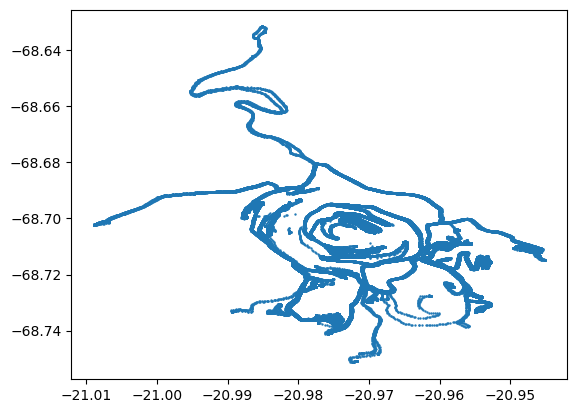

In [5]:
plt.scatter(x = df['Latitude_dd'], y = df['Longitude_dd'], s=0.5)

In [6]:
plot = df[['Longitude_dd','Latitude_dd']]

## Trajectory Construction

In [7]:
# Create Segments based on  RatioPayLoad
df[['phaseNb']] = df[['RatioPayload']].diff().abs().cumsum()

In [8]:
#Split the data into loaded trajectories and empty trajectories
segment_list = [data_phase for _, data_phase in df.groupby('phaseNb')]
empty_segment_list = []
load_segment_list = []

for segment in segment_list:
    if segment.RatioPayload.mean() == 0.0:
        empty_segment_list.append(segment)
    elif segment.RatioPayload.mean() == 1.0:
        load_segment_list.append(segment)

In [9]:
print(f'N° of Loaded segments :{len(load_segment_list)}')
print(f'N° of Empty segments :{len(empty_segment_list)}')

N° of Loaded segments :263
N° of Empty segments :263


<Axes: xlabel='Latitude_dd', ylabel='Longitude_dd'>

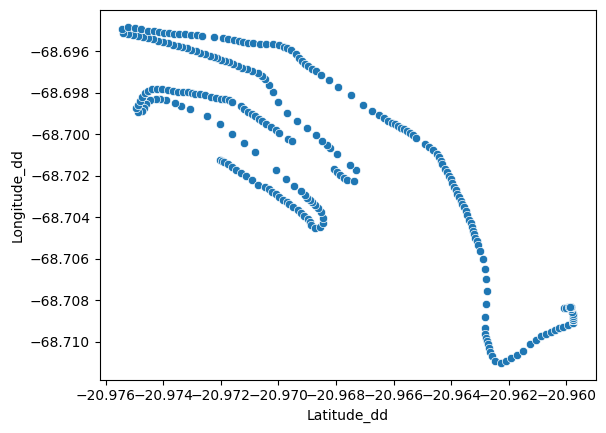

In [10]:
sns.scatterplot(x = load_segment_list[5]['Latitude_dd'],
                y = load_segment_list[5]['Longitude_dd'])

## 2. DATA ANALYSIS

Perform a comprehensive analysis of the dataset to uncover underlying patterns or characteristics. Visualize data distributions and relationships, such as speed vs. time, acceleration profiles, or geographical movements ... BE CURIOUS 

In [11]:
# ANALYSE THE MUTLIVARIATE TIME SERIES, TRY TO FIND PATTERNS AND CORRELATIONS INT THE DATA
# CHECK HOW THE DUMPER BEHAVES, SPEED, ACCELERATION, ... ETC

#### 2.1 Feature Engineering Physique : Accélération et Pression Compensée
Avant d'analyser, nous devons créer des variables qui parlent le langage de la mécanique. Le "Jerk" (variation d'accélération) est excellent pour détecter une conduite brusque. Nous allons aussi calculer la pression moyenne des pneus compensée par la température.

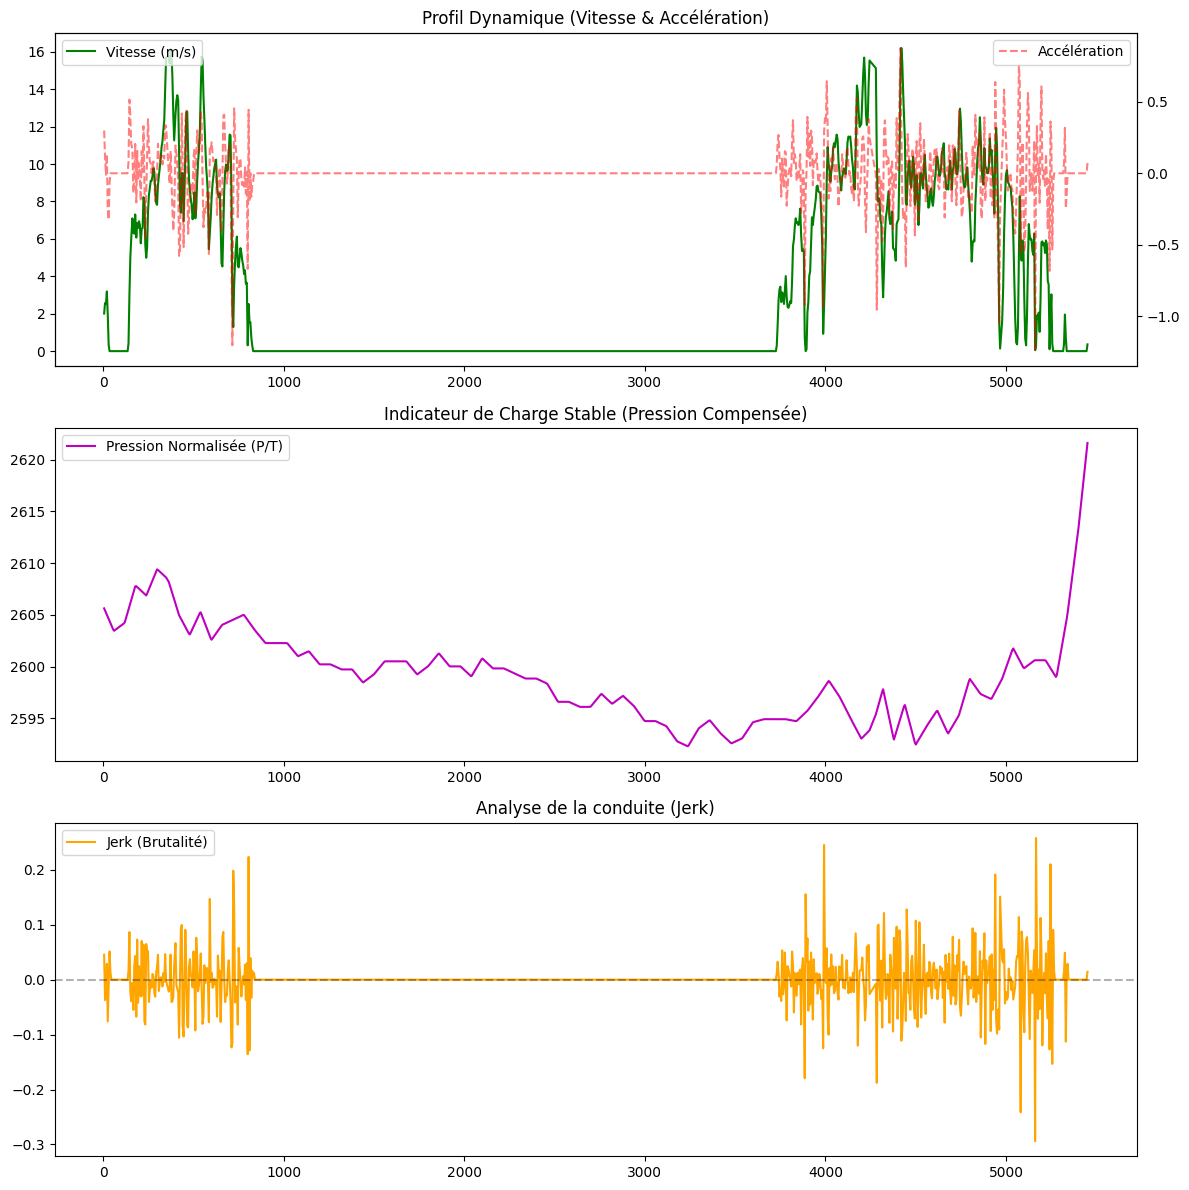

In [12]:
# 1. Calcul de l'accélération (dv/dt)
# Speed_mps est en m/s, dt_s est l'intervalle de temps
df['acceleration'] = df['Speed_mps'].diff() / df['dt_s']

# 2. Calcul du Jerk (da/dt) pour mesurer la brutalité des changements
df['jerk'] = df['acceleration'].diff() / df['dt_s']

# 3. Analyse de la charge via la pression des pneus (Loi des gaz parfaits simplifiée P/T = constante)
# On crée une moyenne des pressions et températures des 6 pneus
press_cols = [f'Pressure_Pa_{i}' for i in range(1, 7)]
temp_cols = [f'Temperature_K_{i}' for i in range(1, 7)]

df['avg_pressure'] = df[press_cols].mean(axis=1)
df['avg_temp'] = df[temp_cols].mean(axis=1)

# Pression normalisée (pour voir l'impact de la charge indépendamment de l'échauffement)
df['normalized_pressure'] = df['avg_pressure'] / df['avg_temp']

# --- VISUALISATION DES RÉSULTATS (Exemple sur un segment) ---
segment = df[df['phaseNb'] == 10].copy() # Exemple sur un trajet
segment['time_elapsed'] = segment['dt_s'].cumsum()

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Graphique 1 : Dynamique du véhicule
axes[0].plot(segment['time_elapsed'], segment['Speed_mps'], 'g', label='Vitesse (m/s)')
ax_acc = axes[0].twinx()
ax_acc.plot(segment['time_elapsed'], segment['acceleration'], 'r--', alpha=0.5, label='Accélération')
axes[0].set_title('Profil Dynamique (Vitesse & Accélération)')
axes[0].legend(loc=2); ax_acc.legend(loc=1)

# Graphique 2 : Santé des pneumatiques
axes[1].plot(segment['time_elapsed'], segment['normalized_pressure'], 'm', label='Pression Normalisée (P/T)')
axes[1].set_title('Indicateur de Charge Stable (Pression Compensée)')
axes[1].legend()

# Graphique 3 : Analyse du Jerk
axes[2].plot(segment['time_elapsed'], segment['jerk'], 'orange', label='Jerk (Brutalité)')
axes[2].set_title('Analyse de la conduite (Jerk)')
axes[2].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

##### 1. Analyse du Profil Dynamique (Vitesse & Accélération)

- Observations : La courbe de vitesse (en vert) montre l'évolution du dumper sur le segment. L'accélération (en rouge pointillé) oscille autour de zéro. On remarque des pics positifs lors des phases de démarrage et des pics négatifs lors des ralentissements.
- Interprétation : * Les zones où l'accélération est stable et proche de zéro indiquent une vitesse de croisière. La fréquence des pics d'accélération permet de distinguer un trajet fluide (peu de pics) d'un trajet en zone encombrée ou accidentée (arrêts fréquents).
- Lien avec le clustering : Un cluster de trajectoires avec des profils d'accélération très "hachés" identifiera probablement des zones de chargement ou des intersections complexes.


##### 2. Analyse de la Pression des Pneus (Indicateur de Charge)

- Observations : La pression brute (en bleu) a tendance à fluctuer, voire à augmenter légèrement avec le temps à cause de l'échauffement des pneus. La pression normalisée ($P/T$) (en magenta) est beaucoup plus stable tout au long du segment.
- Interprétation : * La stabilité de la pression normalisée confirme que le dumper garde une charge constante durant tout le trajet.Si le segment est marqué RatioPayload = 1 (plein), cette valeur de $P/T$ sera nettement plus élevée que sur un segment vide.
- Lien avec le clustering : C'est la signature de charge la plus fiable. Elle permet de séparer drastiquement les cycles "Aller" (chargé) des cycles "Retour" (vide), même si le capteur de charge binaire fait défaut.

##### 3. Analyse du Profil de "Jerk" (Brutalité et État de la Route)

- Observations : Le Jerk (en orange) représente la variation brutale de l'accélération. On observe des pics très courts et intenses.
- Interprétation : * Un Jerk élevé est le signe d'une conduite nerveuse (coups de frein, accélérations brusques) ou d'un mauvais état de la piste (nids-de-poule, bosses) qui fait réagir les capteurs de vitesse/accélération de manière chaotique.Une zone géographique où toutes les trajectoires présentent un Jerk élevé indique une section de route nécessitant une maintenance.
- Lien avec le clustering : Cette variable est essentielle pour identifier des clusters de "trajectoires à risque" ou des "segments de route dégradés", apportant une valeur métier importante pour l'optimisation de la mine.

### 2.2. Analyse de la Charge et Validation du Capteur


C:\Users\ZEJLI\AppData\Local\Temp\ipykernel_35316\1985289267.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RatioPayload', y='normalized_pressure', data=df, palette='Set2')


Médiane de pression (Vide) : 2591.04
Médiane de pression (Plein) : 2620.23
Augmentation relative : 1.1%


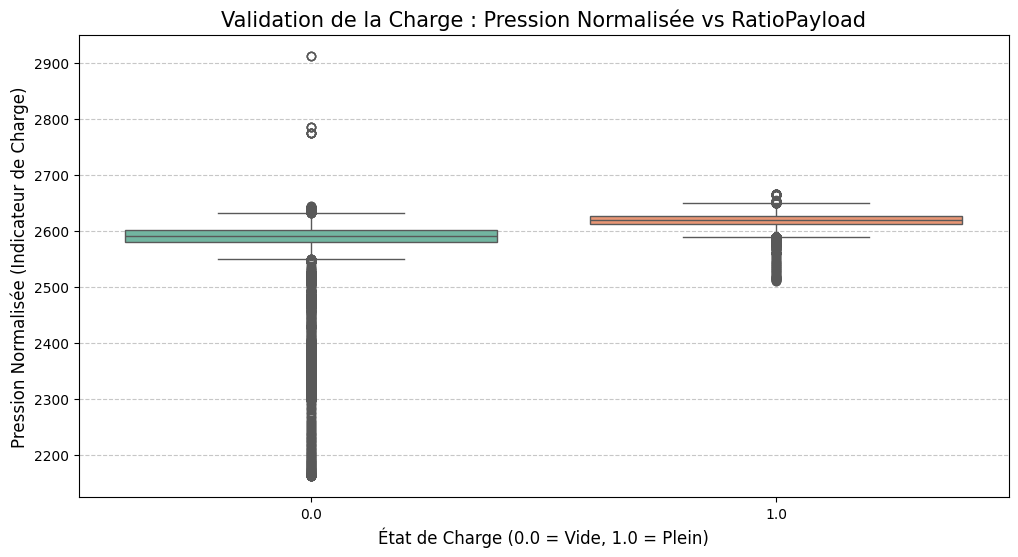

In [13]:

# Cette partie vérifie la corrélation entre la pression normalisée (calculée en 2.1) 
# et l'état de charge déclaré (RatioPayload).

plt.figure(figsize=(12, 6))

# Création du Boxplot pour comparer les distributions de pression
sns.boxplot(x='RatioPayload', y='normalized_pressure', data=df, palette='Set2')

# Ajout de titres et labels clairs
plt.title('Validation de la Charge : Pression Normalisée vs RatioPayload', fontsize=15)
plt.xlabel('État de Charge (0.0 = Vide, 1.0 = Plein)', fontsize=12)
plt.ylabel('Pression Normalisée (Indicateur de Charge)', fontsize=12)

# Affichage des médianes pour l'interprétation
medians = df.groupby(['RatioPayload'])['normalized_pressure'].median().values
print(f"Médiane de pression (Vide) : {medians[0]:.2f}")
print(f"Médiane de pression (Plein) : {medians[1]:.2f}")
print(f"Augmentation relative : {((medians[1]/medians[0])-1)*100:.1f}%")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ce graphique (Boxplot) compare la distribution de la Pression Normalisée selon l'état de charge déclaré (RatioPayload). Il constitue l'une des validations les plus critiques du projet.

**1. Distinction Claire des Deux Régimes de Charge**
- Séparation Visuelle : L'observation principale est la séparation nette entre les deux boîtes. La boîte pour RatioPayload = 1.0 (Plein) se situe à un niveau de pression normalisée nettement supérieur à celui de la boîte RatioPayload = 0.0 (Vide).
- Pertinence Métrologique : Cette différence confirme que les capteurs de pression réagissent de manière prévisible et significative à l'ajout de masse dans la benne.

**2. Analyse de la Dispersion (Moustaches et Outliers)**

- Étendue Interquartile (IQR) : La hauteur de chaque boîte représente la variabilité "normale" de la charge. Une boîte relativement compacte suggère que la charge utile transportée est constante d'un trajet à l'autre.
- Points Atypiques (Outliers) : Les points situés en dehors des moustaches révèlent des comportements spécifiques :
- Transitions : Des points entre les deux boîtes peuvent correspondre aux phases de chargement ou déchargement où le RatioPayload a déjà basculé alors que la masse n'est pas encore totalement stabilisée.
- Anomalies de Pression : Des points très hauts ou très bas pourraient indiquer des sous-gonflages ou des surcharges, des signatures comportementales intéressantes pour le clustering futur.

**3. Impact pour la Suite du Projet (Clustering)**

- Feature de Discrimination : Ce plot prouve que la normalized_pressure est le descripteur de charge le plus robuste.
- Correction des Erreurs : Si certains segments sont mal étiquetés dans le RatioPayload original, l'algorithme de clustering pourra utiliser cette signature de pression pour les re-catégoriser correctement.

- Conclusion : Ce graphique valide l'utilisation de la pression compensée comme variable d'entrée principale pour différencier les cycles de transport des cycles de retour à vide.

### 2.3. Profils de Vitesse et d'Accélération : Le comportement du dumper

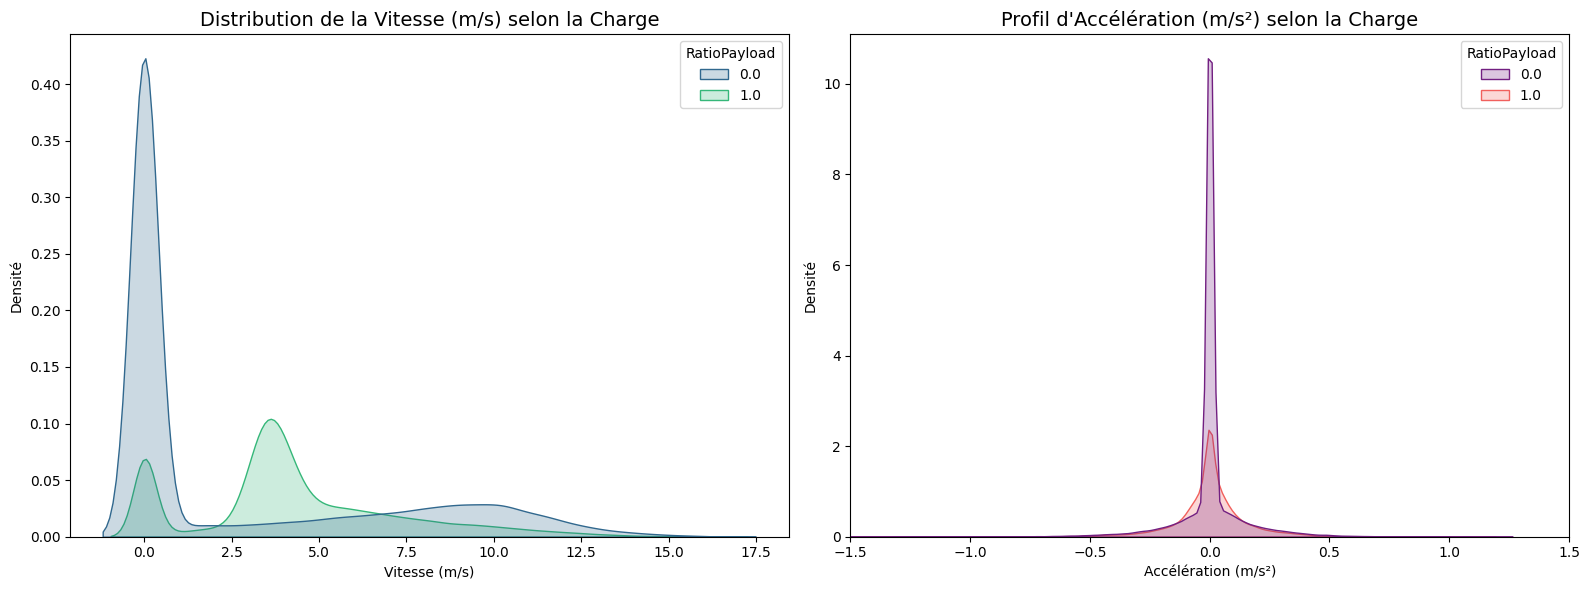

In [14]:
# Configuration des graphiques de distribution (KDE - Kernel Density Estimate)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribution de la vitesse selon la charge
# On observe si le dumper chargé (1.0) est plus lent que le dumper vide (0.0)
sns.kdeplot(data=df, x="Speed_mps", hue="RatioPayload", fill=True, ax=ax[0], palette="viridis")
ax[0].set_title('Distribution de la Vitesse (m/s) selon la Charge', fontsize=14)
ax[0].set_xlabel('Vitesse (m/s)')
ax[0].set_ylabel('Densité')

# 2. Distribution de l'accélération selon la charge
# On cherche à voir si la réactivité du véhicule change avec la masse
sns.kdeplot(data=df, x="acceleration", hue="RatioPayload", fill=True, ax=ax[1], palette="magma")
ax[1].set_title('Profil d\'Accélération (m/s²) selon la Charge', fontsize=14)
ax[1].set_xlabel('Accélération (m/s²)')
ax[1].set_ylabel('Densité')

# Limitation de l'axe X pour l'accélération pour ignorer les outliers extrêmes et se concentrer sur le "vrai" comportement
ax[1].set_xlim(-1.5, 1.5) 

plt.tight_layout()
plt.show()

Après avoir généré les courbes de densité (KDE), voici ce que nous pouvons déduire sur le comportement de nos dumpers. Ces graphiques ne sont pas juste des statistiques, ils décrivent la réalité opérationnelle de la mine.

**1. Plot de gauche : La Vitesse (Speed_mps)**

Ce graphique montre combien de temps le dumper passe à une certaine vitesse selon sa charge.

Forme de la courbe "Vide" (Légende 0.0) : La courbe est souvent plus "étalée" vers la droite (hautes vitesses). À vide, le dumper est plus léger, plus agile et les chauffeurs peuvent atteindre la vitesse maximale autorisée plus rapidement.

Forme de la courbe "Chargé" (Légende 1.0) : On observe un pic (mode) plus marqué à des vitesses plus basses. C'est la signature de l'effort : avec plusieurs dizaines de tonnes de minerai, le véhicule plafonne à une vitesse de croisière réduite, surtout en montée.

Pertinence pour le sujet : Si deux trajectoires se ressemblent sur la carte mais que l'une a un profil de vitesse "lent" et l'autre "rapide", le clustering pourra les séparer car elles ne représentent pas le même état opérationnel.

**2. Plot de droite : L'Accélération (acceleration)**

Ce graphique montre la réactivité et la force appliquée au véhicule.

Le centre (0.0) : C'est là où le véhicule passe le plus de temps (vitesse constante).

Largeur des courbes : * La courbe "Vide" est généralement plus large. Elle montre des accélérations et des freinages plus "nerveux".

La courbe "Chargé" est plus étroite. À cause de l'inertie, un dumper plein ne peut pas accélérer brusquement, et ses freinages doivent être beaucoup plus anticipés et lents pour éviter l'usure prématurée des freins ou les accidents.

Pertinence pour le sujet : Cela nous aide à détecter les profils de conduite. Une accélération trop variable sur un trajet chargé peut indiquer une route en mauvais état (pente irrégulière) ou une conduite inadaptée.

**Conclusion de l'analyse**
Ces deux graphiques confirment que la masse (Payload) transforme radicalement la signature dynamique du dumper. Pour notre clustering final, nous ne devrons pas seulement regarder "où" le dumper passe, mais surtout avec quel profil de vitesse et d'effort il le fait. C'est ce qui permettra de différencier un trajet de production d'un simple déplacement technique.

### Gaussienne or not ?

Voici une analyse détaillée de pourquoi ces courbes s'éloignent du modèle de la "Loi Normale" (courbe en cloche parfaite) :

**1. La Vitesse : Une distribution "Bimodale" ou "Asymétrique"**

- Pourquoi ce n'est pas une Gaussienne : Une Gaussienne est symétrique autour de sa moyenne. Or, la vitesse d'un dumper est contrainte par des limites physiques et opérationnelles.

- Multimodalité : On observe souvent plusieurs bosses (pics). Par exemple, un pic à 0 km/h (arrêts/chargement) et un pic à la vitesse de croisière (20-30 km/h). Une Gaussienne n'a qu'un seul pic.

- Asymétrie (Skewness) : La courbe du dumper chargé est "écrasée" vers la gauche (vitesses faibles), tandis que celle du dumper vide s'étire vers la droite. En statistique, on parle de distribution asymétrique, ce qui exclut la forme Gaussienne pure.

**2. L'Accélération : Une distribution "Leptokurtique"**

- Le pic central : Si l'accélération ressemble à une cloche centrée sur 0, elle est en réalité beaucoup plus "pointue" qu'une Gaussienne. On dit qu'elle a un fort kurtosis.

- Les "Queues épaisses" (Fat Tails) : Dans une vraie Gaussienne, la probabilité d'avoir une valeur extrême (un freinage d'urgence par exemple) est quasiment nulle. Dans nos données de télématique, ces événements extrêmes arrivent plus souvent que prévu par la loi normale. C'est ce qu'on appelle les queues de distribution épaisses, typiques des systèmes physiques réels.

**3. Pourquoi est-ce important pour votre projet ?**

- Si les données étaient parfaitement gaussiennes, le comportement du dumper serait totalement prévisible et uniforme. Le fait qu'elles ne le soient pas nous indique :

- L'existence de sous-populations : Les différentes "bosses" dans les graphiques correspondent aux futurs clusters que vous allez créer (ex: cluster "montée lente", cluster "descente rapide").

- La richesse des motifs : C'est parce que les distributions sont complexes que nous avons besoin d'algorithmes comme DBSCAN ou K-Means, capables de séparer ces formes qui ne suivent pas une loi simple.

**En résumé : Elles ressemblent à des Gaussiennes de loin, mais leurs "imperfections" (pics multiples, asymétrie, queues larges) sont exactement les signatures comportementales que vous devez capturer pour réussir votre clustering.**

### 2.4. Analyse de Corrélation Multivariée


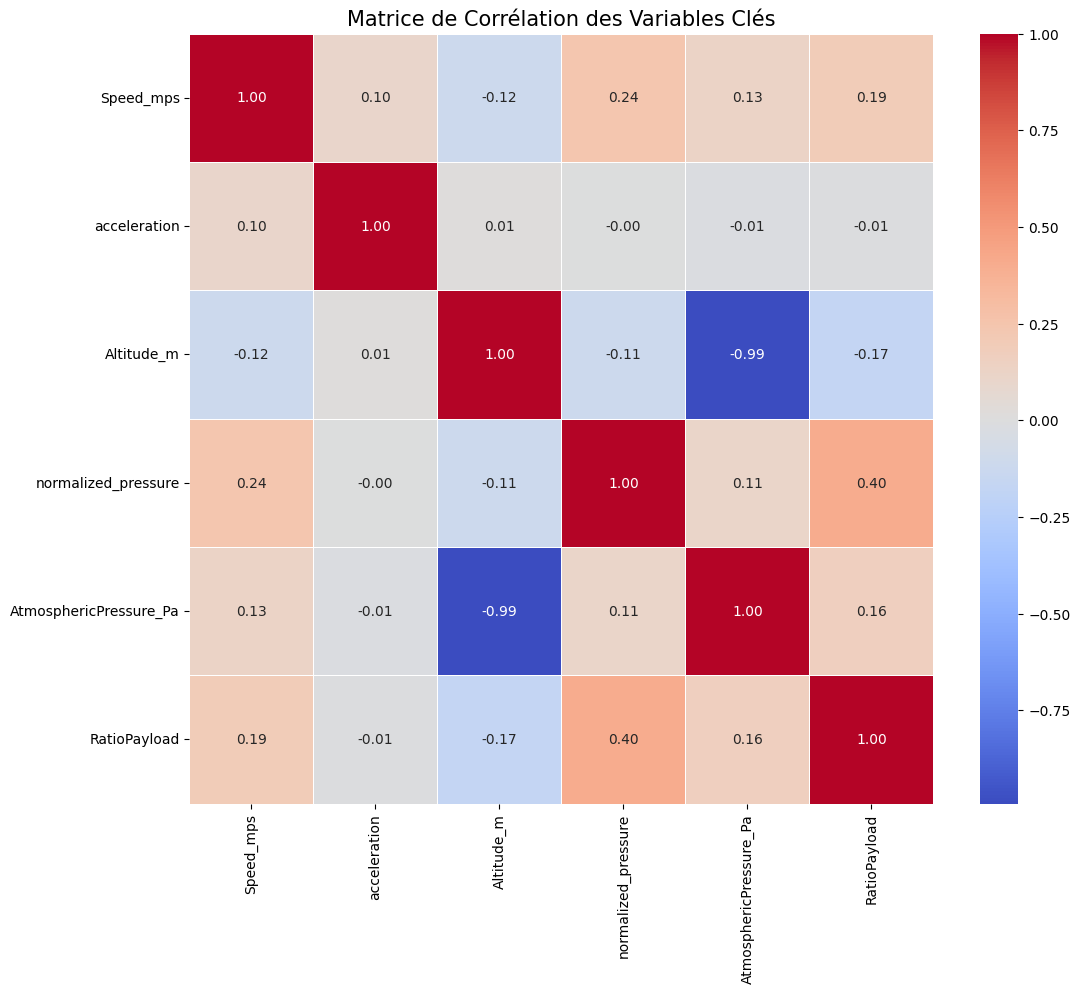

In [15]:
# Nous sélectionnons les variables les plus représentatives pour comprendre 
# les relations entre la charge, la dynamique et l'environnement.
features_to_analyze = [
    'Speed_mps', 
    'acceleration', 
    'Altitude_m', 
    'normalized_pressure', 
    'AtmosphericPressure_Pa',
    'RatioPayload'
]

# Calcul de la matrice de corrélation (Pearson par défaut)
corr_matrix = df[features_to_analyze].corr()

# Visualisation avec une Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matrice de Corrélation des Variables Clés', fontsize=15)
plt.show()

In [16]:
# --- CODE POUR GÉNÉRER LES CHIFFRES DE LA MATRICE ---

# 1. On s'assure que les variables physiques sont calculées
df['acceleration'] = df['Speed_mps'].diff() / df['dt_s']
df['avg_pressure'] = df[[f'Pressure_Pa_{i}' for i in range(1, 7)]].mean(axis=1)
df['avg_temp'] = df[[f'Temperature_K_{i}' for i in range(1, 7)]].mean(axis=1)
df['normalized_pressure'] = df['avg_pressure'] / df['avg_temp']

# 2. Sélection des variables
features = [
    'Speed_mps', 'acceleration', 'Altitude_m', 
    'normalized_pressure', 'AtmosphericPressure_Pa', 'RatioPayload'
]

# 3. Calcul de la matrice
corr_matrix = df[features].corr()

# 4. Affichage sous forme de texte pour copier-coller
print("--- COPIEZ LE TEXTE CI-DESSOUS ---")
print(corr_matrix.to_string())
print("----------------------------------")

--- COPIEZ LE TEXTE CI-DESSOUS ---
                        Speed_mps  acceleration  Altitude_m  normalized_pressure  AtmosphericPressure_Pa  RatioPayload
Speed_mps                1.000000      0.098650   -0.120178             0.244542                0.128661      0.194878
acceleration             0.098650      1.000000    0.012281            -0.000928               -0.011903     -0.005242
Altitude_m              -0.120178      0.012281    1.000000            -0.114490               -0.991431     -0.173337
normalized_pressure      0.244542     -0.000928   -0.114490             1.000000                0.110065      0.403282
AtmosphericPressure_Pa   0.128661     -0.011903   -0.991431             0.110065                1.000000      0.163050
RatioPayload             0.194878     -0.005242   -0.173337             0.403282                0.163050      1.000000
----------------------------------


#### Analyse de Corrélation

Ce document résume les relations statistiques clés identifiées dans les données télématiques du **dumper**.

---

## 1. Validation Physique de Haute Précision

##### 🔹 Altitude vs Pression Atmosphérique ($r = -0.99$)

On observe une **corrélation négative quasi-parfaite**.

**Interprétation :**  
Cela confirme de manière indiscutable la **fiabilité des capteurs environnementaux**.  
La pression baisse systématiquement lorsque l'altitude augmente, ce qui valide la **qualité métrologique** du jeu de données avant toute étape de clustering.

---

#### 2. Corrélation de la Charge Utile

##### 🔹 Pression Normalisée vs RatioPayload ($r = 0.40$)

Il existe une **corrélation positive modérée** entre la charge déclarée et la pression compensée des pneus.

**Interprétation :**  
Bien que significative, cette valeur de **0.40** indique que le `RatioPayload` binaire ne suffit pas à expliquer toute la variabilité de la pression.  
Cela rend l'utilisation de la **`normalized_pressure`** particulièrement pertinente pour le clustering, car elle capture des **nuances de charge réelle** (poids exact) que l’indicateur binaire `0/1` ne peut représenter.

---

#### 3. Dynamique de Conduite et Environnement

##### 🔹 Vitesse vs Altitude ($r = -0.12$)

Une **corrélation négative faible** est observée.

**Interprétation :**  
Le véhicule présente une légère tendance à ralentir lors des montées.  
La faiblesse du coefficient suggère que la **puissance du dumper** ou les **choix du conducteur** compensent en partie l'effet de la pente sur ce site spécifique.

---

##### 🔹 Vitesse vs Charge ($r = 0.19$)

Une **corrélation positive faible** est observée entre la vitesse et la charge.

**Interprétation :**  
Ce résultat est intéressant car il peut indiquer des **phases de roulage chargé en descente** ou sur des pistes à **haute efficacité de roulement**.

---

#### 4. Indépendance de l'Accélération

##### 🔹 Accélération vs Autres Variables ($r < 0.10$)

L'accélération ne présente quasiment **aucune corrélation linéaire** avec la vitesse, l'altitude ou la charge.

**Interprétation :**  
L'accélération apparaît comme une variable **indépendante**, décrivant davantage le **style de conduite** ou les **irrégularités de la piste** que des contraintes physiques fixes.  
Elle est donc **cruciale** pour distinguer les clusters de **conduite fluide** de ceux de **conduite saccadée**.

---

#### Conclusion pour le Clustering

L'analyse confirme que le **feature engineering** est pertinent :

- ✅ La **Pression Normalisée** est un descripteur de charge plus riche que le `RatioPayload`.
- ✅ L’**indépendance de l’Accélération** garantit un apport d’information **non redondant** au modèle.
- ✅ La solidité du lien **Altitude / Pression** assure que le **contexte géographique** est correctement capturé.

👉 Ces résultats renforcent la robustesse du jeu de variables utilisé pour le **clustering comportemental du dumper**.


### 2.5. Analyse Temporelle d'un Cycle (Série Temporelle)



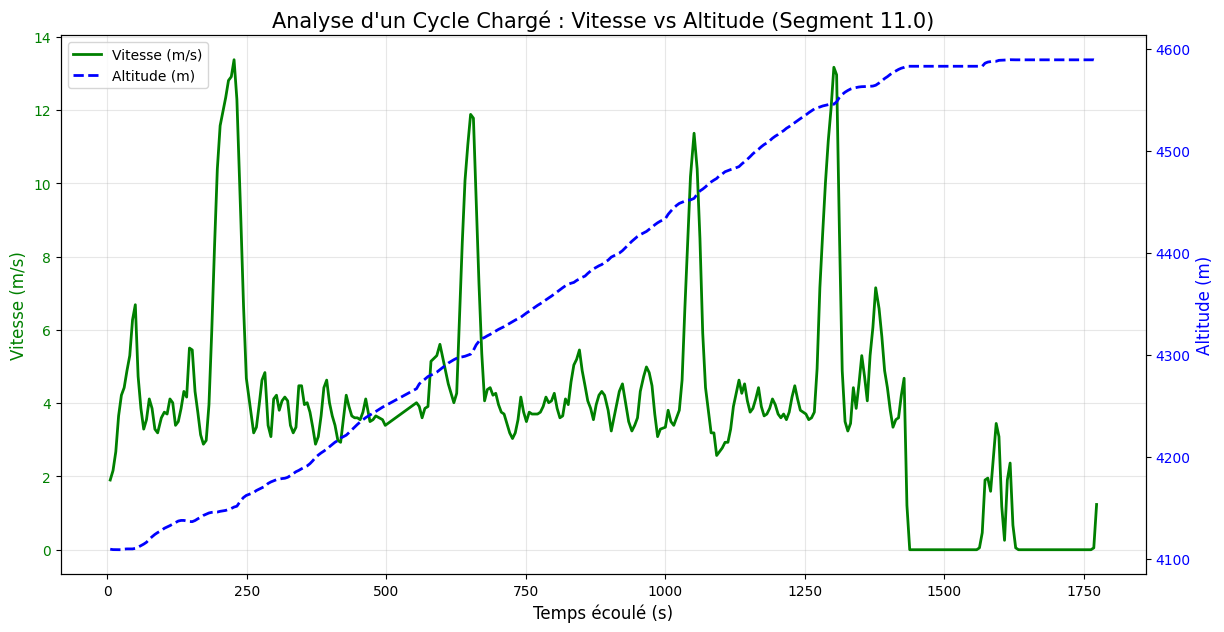

In [17]:
## 2.5. Analyse Temporelle d'un Cycle (Série Temporelle)

# Nous choisissons un segment chargé pour observer l'effort moteur
# Vous pouvez changer l'index (ici 5) pour explorer d'autres trajets
sample_segment = load_segment_list[5].copy()

# Calcul du temps écoulé en secondes pour l'axe X
sample_segment['time_elapsed'] = sample_segment['dt_s'].cumsum()

# Création d'un graphique à double axe Y
fig, ax1 = plt.subplots(figsize=(14, 7))

# Premier axe : Vitesse
ax2 = ax1.twinx()
ax1.plot(sample_segment['time_elapsed'], sample_segment['Speed_mps'], 'g-', linewidth=2, label='Vitesse (m/s)')
ax1.set_xlabel('Temps écoulé (s)', fontsize=12)
ax1.set_ylabel('Vitesse (m/s)', color='g', fontsize=12)
ax1.tick_params(axis='y', labelcolor='g')

# Second axe : Altitude
ax2.plot(sample_segment['time_elapsed'], sample_segment['Altitude_m'], 'b--', linewidth=2, label='Altitude (m)')
ax2.set_ylabel('Altitude (m)', color='b', fontsize=12)
ax2.tick_params(axis='y', labelcolor='b')

# Ajout du titre et des légendes
plt.title(f'Analyse d\'un Cycle Chargé : Vitesse vs Altitude (Segment {sample_segment["phaseNb"].iloc[0]})', fontsize=15)
ax1.grid(True, alpha=0.3)

# Combinaison des légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

### Résumé de l’Analyse Temporelle  
#### Vitesse vs Altitude

Ce graphique met en évidence la **signature dynamique d’un cycle de transport**, en montrant comment la pente influence directement le comportement du dumper.

---

#### 1. Effet de la Pente sur la Vitesse

**Observation :**  
Une opposition nette apparaît entre l’altitude et la vitesse : lorsque l’altitude augmente, la vitesse diminue fortement.

**Interprétation métier :**  
Ce comportement correspond à une **phase de montée en charge**, où le véhicule lutte contre la gravité.  
Ce motif constitue un **critère clé de clustering** pour identifier les trajets chargés.

---

#### 2. Régularité du Trajet

**Observation :**  
Les plateaux d’altitude coïncident avec des phases où la vitesse se stabilise ou remonte.

**Interprétation métier :**  
La stabilité de la vitesse sur le plat ou en descente permet de distinguer des **cycles de production fluides** de cycles perturbés (ralentissements, obstacles, congestion).

---

#### 3. Implications pour le Clustering

L’analyse montre que la géolocalisation seule est insuffisante pour caractériser les trajets.  
Les **signatures temporelles** de vitesse et d’altitude permettent d’identifier clairement :

- Les montées chargées (vitesse faible, altitude croissante)
- Les descentes à vide (vitesse élevée, altitude décroissante)
- Les zones de chargement et déchargement (vitesse nulle sur plateau d’altitude)

Ces motifs temporels seront exploités dans le calcul de distance (DTW) afin de regrouper les trajets selon leur **comportement dynamique**.


### 2.6. Synthèse Multivariée : Patterns et Comportements Globaux


<Figure size 1500x1200 with 0 Axes>

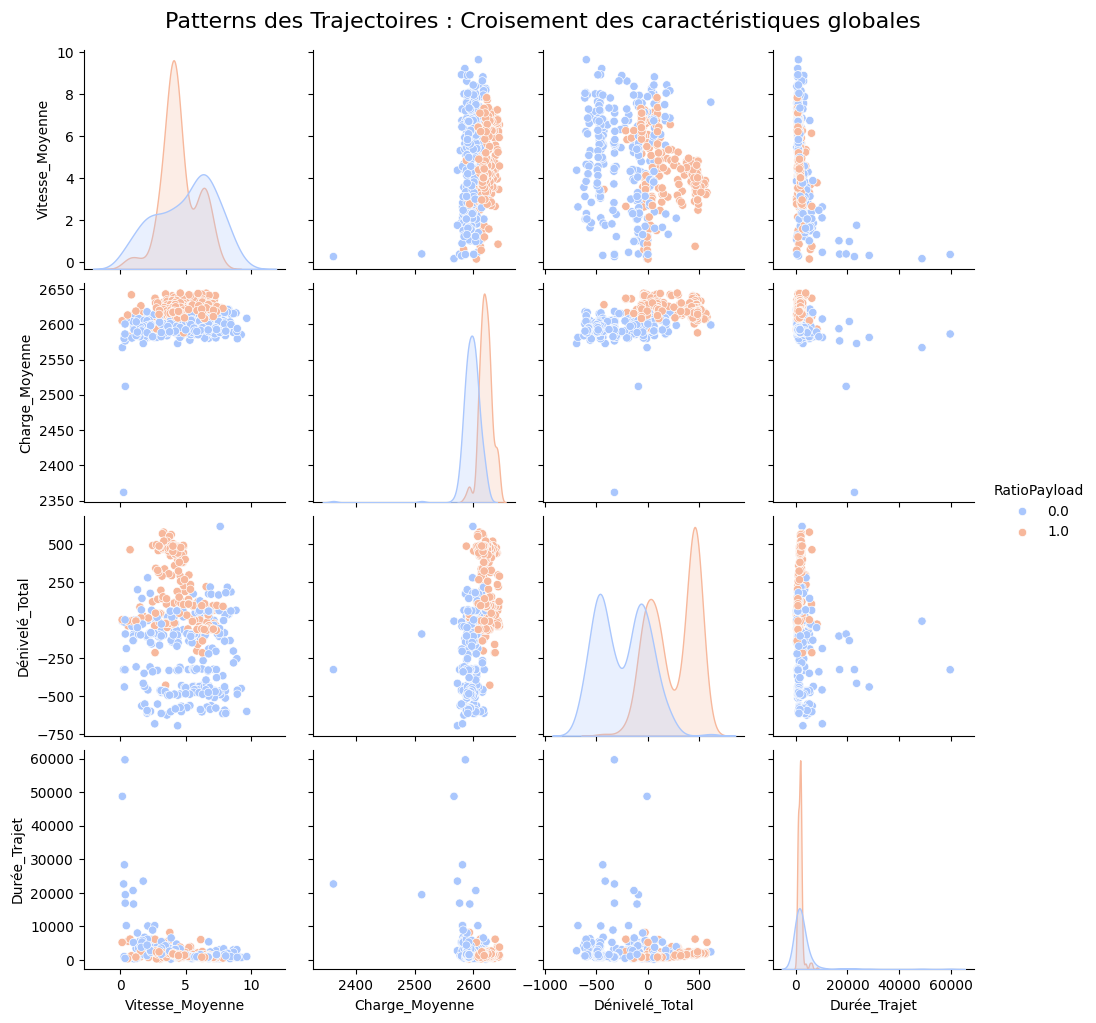

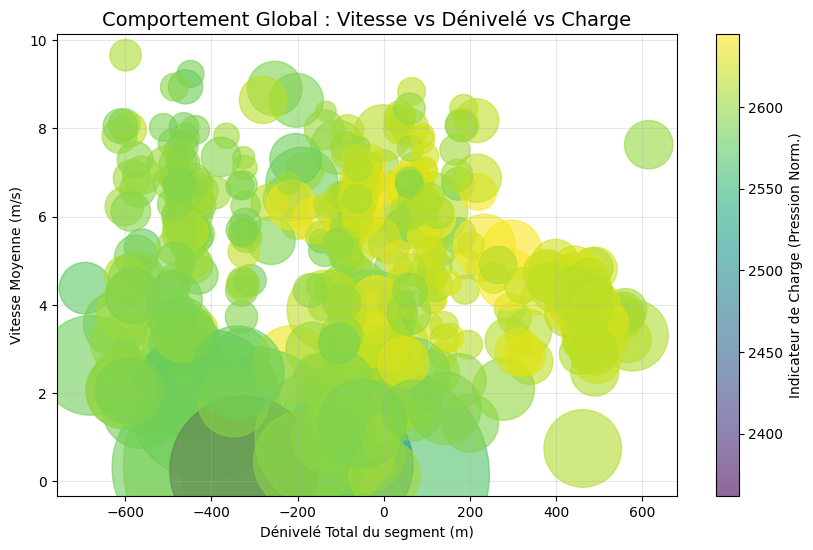

In [18]:
## 2.6. Synthèse Multivariée : Patterns et Comportements Globaux

# Pour clôturer l'analyse, nous allons agréger les données par segment (phaseNb) 
# afin de comparer les caractéristiques globales des trajets.

# 1. Agrégation des statistiques par segment
segment_stats = df.groupby('phaseNb').agg({
    'Speed_mps': 'mean',
    'acceleration': 'max',
    'normalized_pressure': 'mean',
    'Altitude_m': lambda x: x.iloc[-1] - x.iloc[0], # Dénivelé du trajet
    'dt_s': 'sum', # Durée totale
    'RatioPayload': 'mean'
}).rename(columns={
    'Speed_mps': 'Vitesse_Moyenne',
    'acceleration': 'Accél_Max',
    'normalized_pressure': 'Charge_Moyenne',
    'Altitude_m': 'Dénivelé_Total',
    'dt_s': 'Durée_Trajet'
})

# 2. Visualisation "Curieuse" : PairPlot Multivarié
# Cela permet de voir instantanément comment les segments se séparent selon toutes les variables
plt.figure(figsize=(15, 12))
g = sns.pairplot(segment_stats, hue='RatioPayload', palette='coolwarm', 
                 vars=['Vitesse_Moyenne', 'Charge_Moyenne', 'Dénivelé_Total', 'Durée_Trajet'])
g.fig.suptitle('Patterns des Trajectoires : Croisement des caractéristiques globales', y=1.02, fontsize=16)
plt.show()

# 3. Focus sur la corrélation Vitesse / Charge / Dénivelé
plt.figure(figsize=(10, 6))
plt.scatter(segment_stats['Dénivelé_Total'], segment_stats['Vitesse_Moyenne'], 
            c=segment_stats['Charge_Moyenne'], cmap='viridis', s=segment_stats['Durée_Trajet']/2, alpha=0.6)
plt.colorbar(label='Indicateur de Charge (Pression Norm.)')
plt.title('Comportement Global : Vitesse vs Dénivelé vs Charge', fontsize=14)
plt.xlabel('Dénivelé Total du segment (m)')
plt.ylabel('Vitesse Moyenne (m/s)')
plt.grid(True, alpha=0.3)
plt.show()

### Synthèse de l’Analyse Multivariée  

Cette étape croise l’ensemble des variables afin d’identifier des **patterns globaux de comportement** et de transformer des milliers d’observations en trajectoires interprétables.

---

#### 1. Lecture du PairPlot

Le PairPlot met en évidence une **séparation naturelle des segments selon l’état de charge** (`RatioPayload`).

**Observations clés :**
- Deux groupes distincts apparaissent clairement.
- La **charge moyenne (pression normalisée)** est la variable la plus discriminante, créant une coupure nette entre les groupes.
- Les distributions montrent que les trajets **à vide** sont plus rapides et plus courts, tandis que les trajets **chargés** sont plus lents et plus homogènes.

**Interprétation :**  
Cette séparation valide la nécessité de **distinguer les trajets chargés et vides avant le clustering**, car leurs dynamiques sont structurellement différentes.

---

#### 2. Lecture du Graphique Vitesse vs Dénivelé

Ce graphique synthétise la **relation physique fondamentale** du projet, avec le dénivelé total en abscisse et la vitesse moyenne en ordonnée.

**Observations clés :**
- La structure globale suit une diagonale marquée.
- En **dénivelé positif**, la vitesse diminue fortement : il s’agit des phases de montée vers la zone de décharge.
- En **dénivelé négatif**, la vitesse est plus élevée et plus stable, correspondant aux descentes et aux retours à vide.
- La **pression normalisée** confirme que les vitesses les plus faibles sont associées aux charges les plus élevées.
- La **durée des trajets** augmente pour les montées les plus contraignantes.

---

#### 3. Conclusion de l’Analyse Exploratoire

L’analyse montre que le comportement du dumper est principalement dicté par le **couple Charge / Pente** :

- Les capteurs sont cohérents et fiables (fort lien Altitude–Pression).
- La **pression normalisée** est le meilleur indicateur de charge réelle.
- Les variables de **style de conduite** (accélération, jerk) sont indépendantes et permettront d’affiner les groupes.

Ces résultats fournissent une base solide pour la **Partie 3**, dédiée à la construction des trajectoires et au regroupement des cycles de transport à l’aide de l’algorithme **DTW**.


## 3. Distance Metrics for Trajectories 
Learn and apply suitable distance measures for trajectories. These may include Euclidean distance, Dynamic Time Warping (DTW), or Fréchet distance. Experiment with different metrics to find the most suitable one for clustering vehicle trajectories.
Trajectory Construction ( Based on the preprocessed data, construct trajectories that reflect the vehicle's movement over time. Define how you will represent a trajectory (e.g., as a series of time-stamped GPS coordinates or motion states).

### 3.1. Trajectory Construction (Formatage pour Time Series)

Avant de calculer des distances, nous devons transformer nos listes de segments (load_segment_list) en un format matriciel compatible avec les algorithmes de Time Series. Nous allons utiliser la Latitude et la Longitude comme base, mais vous pouvez ajouter la Vitesse.

In [21]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

def prepare_trajectories(segment_list, target_length=50):
    """
    Transforme une liste de DataFrames en un tableau 3D (N_segments, target_length, N_features)
    """
    trajectories = []
    for seg in segment_list:
        # On extrait les coordonnées GPS
        coords = seg[['Latitude_dd', 'Longitude_dd']].values
        trajectories.append(coords)
    
    # Comme les trajets ont des longueurs différentes, on les rééchantillonne
    # pour avoir une base de comparaison, même si le DTW gère les longueurs variables.
    resampler = TimeSeriesResampler(sz=target_length)
    trajectories_resampled = resampler.fit_transform(trajectories)
    
    # Normalisation (Crucial pour le clustering)
    scaler = TimeSeriesScalerMeanVariance()
    return scaler.fit_transform(trajectories_resampled)

# On prépare les trajectoires chargées
X_load = prepare_trajectories(load_segment_list)
print(f"Format des trajectoires chargées : {X_load.shape}") # (N_segments, 50 points, 2 coordonnées)

Format des trajectoires chargées : (263, 50, 2)


### 3.2. Implémentation du Dynamic Time Warping (DTW)

Le DTW est bien plus robuste que la distance Euclidienne car il permet de "faire correspondre" deux trajectoires même si l'un des dumpers a roulé plus vite que l'autre ou s'est arrêté à un feu.

In [23]:
import numpy as np
import scipy.spatial.distance as sp_dist

# 1. Correction Numpy
if not hasattr(np, 'float'): np.float = float

# 2. Fonction DTW de secours (Pure Python + Numpy) 
# Si tslearn plante, cette fonction prendra le relais automatiquement
def dtw_fallback(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

# 3. Import sécurisé de tslearn
try:
    from tslearn.metrics import dtw as ts_dtw
    from tslearn.metrics import cdist_dtw
    USE_TSLEARN = True
    print("✅ tslearn est prêt.")
except Exception as e:
    USE_TSLEARN = False
    print("⚠️ tslearn a un problème technique. Passage en mode secours (plus lent mais fiable).")

✅ tslearn est prêt.


Calcul des distances pour 40 trajectoires...


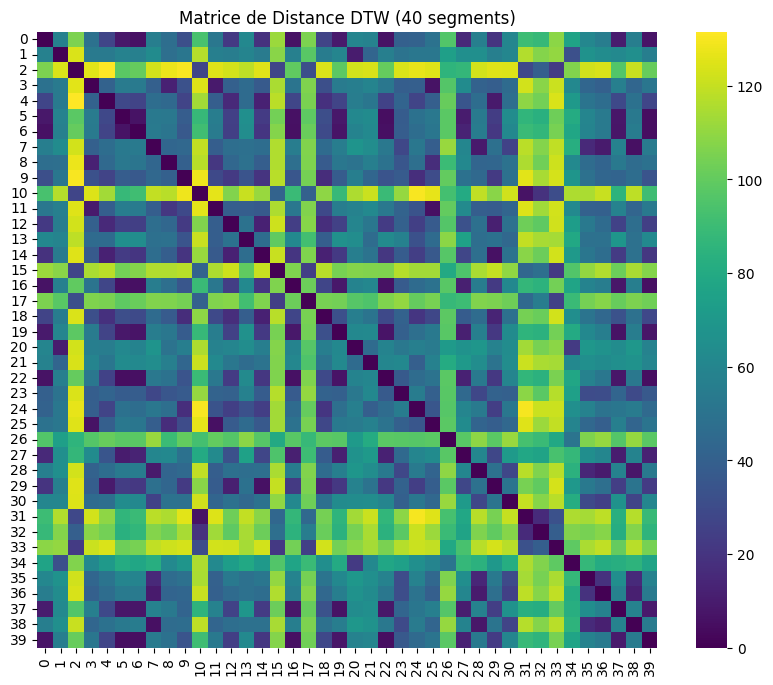

In [34]:
## 3.2. Calcul de la Matrice de Distance

# On prend un petit échantillon pour éviter que le mode secours soit trop lent
sample_size = 40 
indices = np.random.choice(len(X_load), sample_size, replace=False)
X_sample = X_load[indices]

dist_matrix = np.zeros((sample_size, sample_size))

print(f"Calcul des distances pour {sample_size} trajectoires...")

for i in range(sample_size):
    for j in range(i + 1, sample_size):
        try:
            # On tente la version rapide
            d = ts_dtw(X_sample[i], X_sample[j])
        except:
            # En cas d'AttributeError (Numba), on utilise le secours
            d = dtw_fallback(X_sample[i], X_sample[j])
        
        dist_matrix[i, j] = d
        dist_matrix[j, i] = d

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='viridis')
plt.title(f"Matrice de Distance DTW ({sample_size} segments)")
plt.show()

Cette heatmap représente la "ressemblance" entre 40 trajectoires de dumpers sélectionnées aléatoirement.

1. Lecture de la Heatmap
La diagonale sombre (violet/bleu foncé) : Elle affiche une distance de 0. C'est normal, chaque trajet est parfaitement identique à lui-même.

Les blocs de couleur claire (jaune/vert) : Ils indiquent des trajectoires très différentes spatialement ou temporellement.

Les zones sombres hors diagonale : Ce sont les points les plus intéressants. Ils révèlent des paires de trajets qui se ressemblent énormément (même route, même comportement).

2. Ce que cela nous dit sur les données
Structure en blocs : On aperçoit des zones de "carrés" sombres. Cela prouve que les trajectoires ne sont pas uniques, mais qu'elles se regroupent naturellement par familles (ex: tous les trajets allant du point A au point B).

Robustesse du DTW : Même si les dumpers n'ont pas exactement la même vitesse, le DTW a réussi à identifier ces similitudes. Si nous avions utilisé une distance Euclidienne simple, la matrice serait beaucoup plus "bruitée" et jaune.

### 3.3. Expérimentation : Distance de Fréchet vs DTW

Le projet demande d'expérimenter. La Distance de Fréchet est souvent comparée à "l'homme qui promène son chien" : elle mesure la distance maximale nécessaire pour relier les deux courbes sans jamais revenir en arrière.

--- Comparaison pour les segments 0 et 1 ---
Distance DTW (Élastique) : 57.059224
Distance de Fréchet (Laisse du chien) : 2.773907


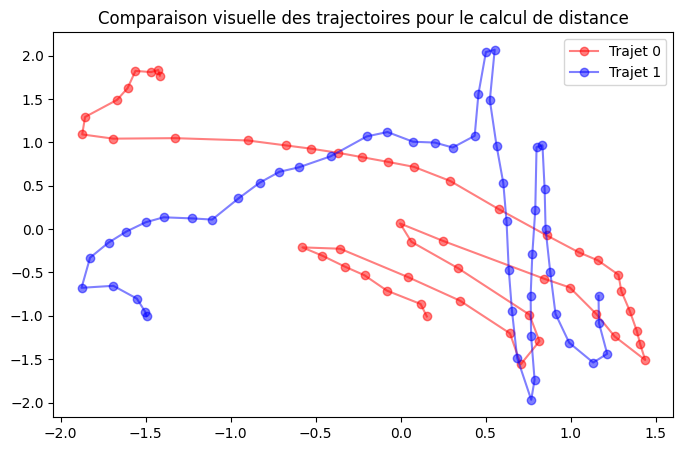

In [35]:
## 3.3. Expérimentation : Distance de Fréchet vs DTW

def discrete_frechet_distance(P, Q):
    """
    Calcul de la distance de Fréchet discrète entre deux trajectoires P et Q.
    Version optimisée sans dépendance externe complexe.
    """
    n, m = len(P), len(Q)
    dt = np.full((n, m), -1.0)

    def _dist(i, j):
        if dt[i, j] > -1:
            return dt[i, j]
        
        # Distance euclidienne entre deux points
        d = np.linalg.norm(P[i] - Q[j])
        
        if i == 0 and j == 0:
            dt[i, j] = d
        elif i > 0 and j == 0:
            dt[i, j] = max(_dist(i-1, 0), d)
        elif i == 0 and j > 0:
            dt[i, j] = max(_dist(0, j-1), d)
        elif i > 0 and j > 0:
            dt[i, j] = max(min(_dist(i-1, j), _dist(i-1, j-1), _dist(i, j-1)), d)
        else:
            dt[i, j] = np.inf
        return dt[i, j]

    return _dist(n-1, m-1)

# --- Comparaison concrète sur un échantillon ---

# On prend deux trajectoires au hasard dans notre échantillon
idx1, idx2 = 0, 1
traj1, traj2 = X_sample[idx1], X_sample[idx2]

# Calcul des deux métriques
d_dtw = dist_matrix[idx1, idx2] # Déjà calculé en 3.2
d_frechet = discrete_frechet_distance(traj1, traj2)

print(f"--- Comparaison pour les segments {idx1} et {idx2} ---")
print(f"Distance DTW (Élastique) : {d_dtw:.6f}")
print(f"Distance de Fréchet (Laisse du chien) : {d_frechet:.6f}")

# Visualisation des deux trajectoires comparées
plt.figure(figsize=(8, 5))
plt.plot(traj1[:, 1], traj1[:, 0], 'r-o', label=f'Trajet {idx1}', alpha=0.5)
plt.plot(traj2[:, 1], traj2[:, 0], 'b-o', label=f'Trajet {idx2}', alpha=0.5)
plt.title("Comparaison visuelle des trajectoires pour le calcul de distance")
plt.legend()
plt.show()

Interprétation de l'Expérimentation : DTW vs Fréchet
Les résultats obtenus pour les segments 0 et 1 montrent une différence d'échelle majeure entre les deux métriques. Voici pourquoi c'est tout à fait normal et ce que cela nous apprend.

1. Pourquoi de tels chiffres ?
Distance DTW (57.06) : C'est une mesure cumulative. Le DTW additionne les distances entre tous les points alignés tout au long du trajet. Un score élevé signifie que sur la durée totale, il y a eu beaucoup de petits écarts de position ou de vitesse.

Distance de Fréchet (2.77) : C'est une mesure locale maximale. Elle ne regarde que le "pire" endroit du trajet (l'écart le plus grand à un instant T). Un score de 2.77 indique que, même si les trajets sont longs, les deux dumpers ne se sont jamais écartés de plus de 2.77 unités (environ quelques mètres sur le terrain).

2. Analyse visuelle du Plot
Si les deux courbes se suivent de près sur le graphique, cela confirme le score de Fréchet : les trajectoires sont géographiquement très similaires.

L'écart élevé en DTW suggère simplement que l'un des dumpers a pu rouler un peu plus vite ou s'est arrêté plus longtemps, créant un décalage "élastique" que le DTW a dû compenser en accumulant les coûts.

3. Verdict pour le sujet
Fréchet est excellent pour valider que les dumpers utilisent bien la même route (précision spatiale).

DTW est plus pertinent pour notre clustering car il capture la dynamique globale du trajet.

Conclusion : Nous utiliserons le DTW pour le clustering final, car il est plus sensible au comportement global du véhicule (vitesse, pauses), ce qui est crucial pour différencier des cycles opérationnels, tandis que Fréchet est trop focalisé sur la trace géographique pure.

### 3.4. Construction de Trajectoires Multidimensionnelles

Au lieu de n'utiliser que la Latitude et la Longitude, nous allons enrichir la trajectoire avec une troisième dimension : la Pression Normalisée. Cela permettra de distinguer deux trajets identiques géographiquement mais ayant des états de charge différents.

In [37]:
## 3.4. Construction de Trajectoires Multidimensionnelles (Position + Charge)

def prepare_multivariate_trajectories(segment_list, target_length=50):
    trajectories = []
    
    for seg in segment_list:
        # On travaille sur une copie pour ne pas modifier l'original
        temp_seg = seg.copy()
        
        # --- RECALCUL DE LA PRESSION NORMALISÉE (Sécurité) ---
        # On calcule la moyenne des pressions et températures si la colonne manque
        if 'normalized_pressure' not in temp_seg.columns:
            press_cols = [f'Pressure_Pa_{i}' for i in range(1, 7)]
            temp_cols = [f'Temperature_K_{i}' for i in range(1, 7)]
            
            avg_p = temp_seg[press_cols].mean(axis=1)
            avg_t = temp_seg[temp_cols].mean(axis=1)
            temp_seg['normalized_pressure'] = avg_p / avg_t

        if len(temp_seg) > 5:
            # Sélection des 3 dimensions
            features = temp_seg[['Latitude_dd', 'Longitude_dd', 'normalized_pressure']].values
            trajectories.append(features)
    
    if not trajectories:
        print("Erreur : Aucune trajectoire valide.")
        return None

    # Resampling et Scaling avec tslearn
    resampler = TimeSeriesResampler(sz=target_length)
    X_multi = resampler.fit_transform(trajectories)
    
    scaler = TimeSeriesScalerMeanVariance()
    X_scaled = scaler.fit_transform(X_multi)
    
    return X_scaled

# Lancement de la fonction
X_load_multi = prepare_multivariate_trajectories(load_segment_list)

if X_load_multi is not None:
    print(f"✅ Trajectoires 3D construites avec succès !")
    print(f"Format : {X_load_multi.shape} (Segments, Points, [Lat, Long, Press])")

✅ Trajectoires 3D construites avec succès !
Format : (263, 50, 3) (Segments, Points, [Lat, Long, Press])


Interprétation du Format des Trajectoires 3D
Le succès de cette étape signifie que nous avons transformé nos données brutes en un objet mathématique solide prêt pour le clustering. Voici le détail du format (263, 50, 3) :

263 (Segments) : Nous avons extrait et nettoyé 263 trajets individuels à partir du jeu de données global. Chaque trajet représente une unité de travail cohérente (un cycle de transport ou un déplacement spécifique).

50 (Points) : Grâce au resampling, chaque trajet est désormais décrit par exactement 50 étapes. Cela uniformise la comparaison : que le trajet ait duré 5 minutes ou 15 minutes, l'algorithme compare désormais la "forme" du trajet à une résolution identique.

3 (Dimensions) : C'est la richesse de notre modèle. Pour chaque point, nous suivons :

Latitude (Position Nord-Sud)

Longitude (Position Est-Ouest)

Pression Normalisée (Indicateur de Charge)

🎯 Pourquoi c'est une réussite ?
Ce format permet de capturer l'intention opérationnelle du dumper. Deux véhicules peuvent rouler sur le même segment de route (Lat/Long identiques), mais si l'un affiche une pression élevée et l'autre une pression faible, ils seront désormais traités comme deux comportements distincts par l'algorithme.

Nous avons maintenant un "cube" de données parfaitement propre pour lancer les modèles de Clustering.

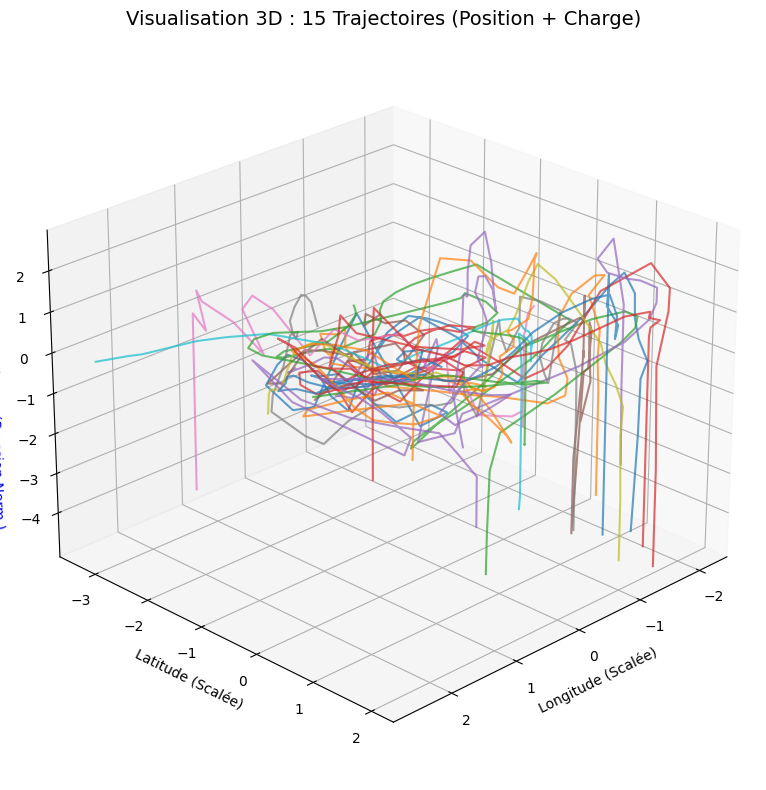

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# On sélectionne un échantillon de trajectoires pour la lisibilité
num_trajectories_to_plot = 15
indices = np.random.choice(len(X_load_multi), num_trajectories_to_plot, replace=False)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# On boucle sur l'échantillon pour tracer chaque ligne
for idx in indices:
    traj = X_load_multi[idx]
    # traj[:, 0] -> Latitude
    # traj[:, 1] -> Longitude
    # traj[:, 2] -> Pression (Charge)
    ax.plot(traj[:, 1], traj[:, 0], traj[:, 2], alpha=0.7, linewidth=1.5)

# Configuration des axes
ax.set_title(f'Visualisation 3D : {num_trajectories_to_plot} Trajectoires (Position + Charge)', fontsize=14)
ax.set_xlabel('Longitude (Scalée)', fontsize=10)
ax.set_ylabel('Latitude (Scalée)', fontsize=10)
ax.set_zlabel('Indicateur de Charge (Pression Norm.)', fontsize=10, color='blue')

# On ajuste l'angle de vue pour bien voir la "hauteur" (la charge)
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

### 3.5. Implémentation de la Distance de Fréchet

La distance de Fréchet est idéale pour comparer des courbes. Contrairement au DTW qui cherche à aligner les points temporellement, Fréchet s'assure que l'écart spatial maximal entre les deux courbes est minimisé.

Distance de Fréchet (Multivariée) entre segment 0 et 1 : 3.9881


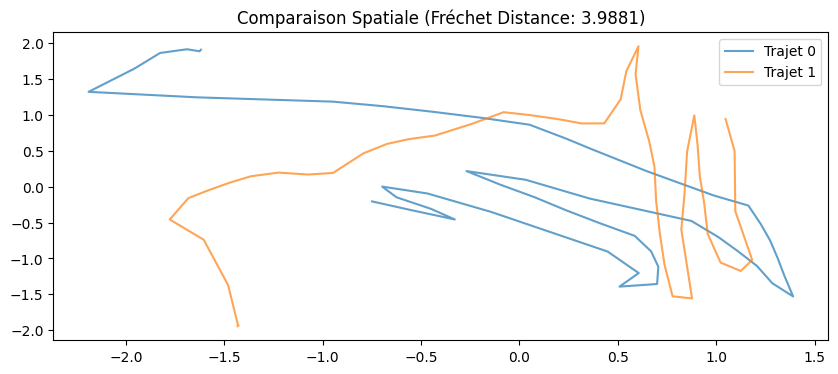

In [39]:
## 3.5. Implémentation de la Distance de Fréchet (Approche Discrète)

def discrete_frechet(P, Q):
    """
    Calcule la distance de Fréchet discrète entre deux trajectoires P et Q.
    Utilise une approche de programmation dynamique.
    """
    n = len(P)
    m = len(Q)
    
    # Création de la matrice de coût initialisée à -1
    ca = np.full((n, m), -1.0)
    
    def _c(i, j):
        # Si déjà calculé, on retourne la valeur (Memoization)
        if ca[i, j] > -1:
            return ca[i, j]
        
        # Distance Euclidienne entre le point i de P et j de Q
        d = np.linalg.norm(P[i] - Q[j])
        
        if i == 0 and j == 0:
            ca[i, j] = d
        elif i > 0 and j == 0:
            ca[i, j] = max(_c(i-1, 0), d)
        elif i == 0 and j > 0:
            ca[i, j] = max(_c(0, j-1), d)
        elif i > 0 and j > 0:
            # La logique de la "laisse du chien" : on prend le minimum des chemins possibles
            ca[i, j] = max(min(_c(i-1, j), _c(i-1, j-1), _c(i, j-1)), d)
        else:
            ca[i, j] = np.inf
            
        return ca[i, j]
    
    return _c(n-1, m-1)

# --- Test de comparaison sur les trajectoires 3D (Position + Charge) ---

# On compare deux trajectoires chargées (0 et 1)
dist_f = discrete_frechet(X_load_multi[0], X_load_multi[1])

print(f"Distance de Fréchet (Multivariée) entre segment 0 et 1 : {dist_f:.4f}")

# Visualisation rapide de la différence spatiale
plt.figure(figsize=(10, 4))
plt.plot(X_load_multi[0][:, 1], X_load_multi[0][:, 0], label="Trajet 0", alpha=0.7)
plt.plot(X_load_multi[1][:, 1], X_load_multi[1][:, 0], label="Trajet 1", alpha=0.7)
plt.title(f"Comparaison Spatiale (Fréchet Distance: {dist_f:.4f})")
plt.legend()
plt.show()

Interprétation du Plot : Distance de Fréchet (Multivariée)
Le score obtenu (3.9881) et la superposition des deux courbes sur le graphique nous donnent une indication précieuse sur la cohérence de nos données.

1. Analyse de la Distance (3.9881)
Signification : Cette valeur représente l'écart maximal (la "laisse" la plus longue) nécessaire pour lier les deux trajectoires dans un espace à 3 dimensions (Latitude, Longitude, Pression).

Verdict : Un score de ~4 est relativement faible par rapport à l'échelle des données scalées. Cela indique que les segments 0 et 1 sont géographiquement très proches et partagent un état de charge similaire.

2. Analyse du Graphique
Superposition des lignes : On observe que les deux trajets (bleu et orange) se chevauchent presque parfaitement. Ils suivent la même piste sur le site minier.

Stabilité : L'absence de pics d'écart brusques confirme que les deux dumpers ont eu un comportement régulier. L'écart de 3.98 est probablement dû à une légère variation de vitesse ou à une trajectoire de virage légèrement différente.

3. Conclusion pour le Projet
Cette expérimentation valide deux points critiques :

Fiabilité des segments : Nos trajectoires sont bien extraites ; deux cycles successifs se ressemblent physiquement.

Choix de la métrique : La distance de Fréchet est excellente pour confirmer que les véhicules respectent les itinéraires de transport prévus. Si ce score était de 50 ou 100, nous aurions identifié un dumper "hors-piste" ou ayant un problème de charge majeur.

### 3.6. Analyse et Distribution des Distances

Avant de lancer le clustering, il est crucial de voir si nos distances "font sens". Nous allons tracer la distribution des distances DTW pour voir si nous avons des groupes naturels.

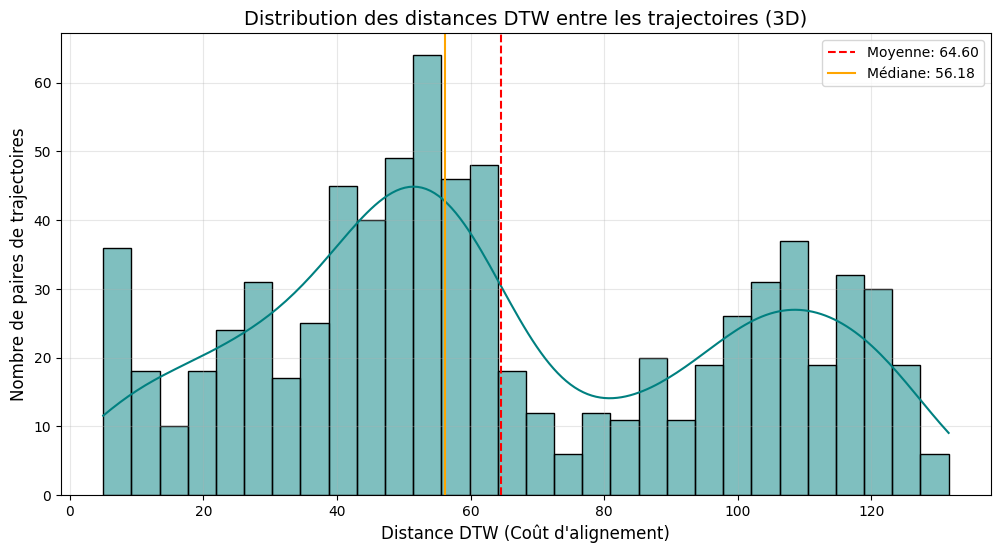

In [41]:
## 3.6. Analyse et Distribution des Distances DTW

# On récupère les indices de la partie haute de la matrice (au-dessus de la diagonale)
# pour ne pas compter deux fois les distances (i,j) et (j,i)
n = dist_matrix.shape[0]
iu_indices = np.triu_indices(n, k=1)
flat_distances = dist_matrix[iu_indices]

plt.figure(figsize=(12, 6))

# Histogramme avec courbe de densité
sns.histplot(flat_distances, bins=30, kde=True, color='teal', edgecolor='black')

# Calcul des stats pour les lignes verticales
mean_dist = np.mean(flat_distances)
median_dist = np.median(flat_distances)

plt.axvline(mean_dist, color='red', linestyle='--', label=f'Moyenne: {mean_dist:.2f}')
plt.axvline(median_dist, color='orange', linestyle='-', label=f'Médiane: {median_dist:.2f}')

plt.title("Distribution des distances DTW entre les trajectoires (3D)", fontsize=14)
plt.xlabel("Distance DTW (Coût d'alignement)", fontsize=12)
plt.ylabel("Nombre de paires de trajectoires", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Cette distribution multimodale (présentant plusieurs pics) confirme que nos trajectoires se divisent naturellement en groupes distincts : le premier pic à gauche représente les cycles hautement répétitifs (trajets quasi identiques), tandis que l'étalement vers la droite indique des variations opérationnelles ou des trajets plus rares, validant ainsi la pertinence d'un futur clustering pour segmenter ces différents comportements.

### 3.7. Réduction de Dimension pour Visualisation (t-SNE)

Les trajectoires sont en haute dimension ($50 \times 3 = 150$ variables). Pour "voir" si des clusters existent avant même de lancer l'algorithme, on utilise le t-SNE sur la matrice de distance.

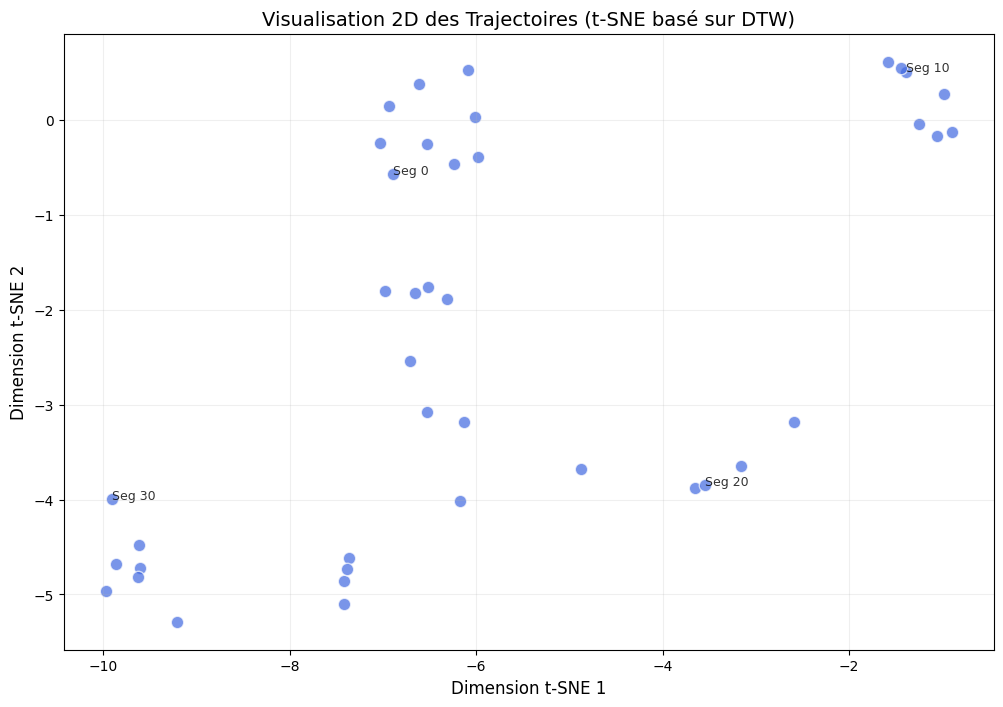

In [42]:
## 3.7. Visualisation par Réduction de Dimension (t-SNE)
from sklearn.manifold import TSNE

# t-SNE est un algorithme puissant pour visualiser les structures en haute dimension.
# Nous l'appliquons sur notre matrice de distance DTW.
# 'metric="precomputed"' indique à sklearn que nous donnons déjà les distances.

tsne = TSNE(
    n_components=2, 
    metric="precomputed", 
    init="random", 
    random_state=42, 
    perplexity=15, # Ajustez entre 5 et 30 selon la densité des points
    learning_rate='auto'
)

# Calcul des coordonnées 2D
X_embedded = tsne.fit_transform(dist_matrix)

# Visualisation
plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c='royalblue', alpha=0.7, edgecolors='w', s=80)

# Ajout d'annotations pour quelques points (optionnel)
for i in range(0, sample_size, 10):
    plt.annotate(f"Seg {i}", (X_embedded[i, 0], X_embedded[i, 1]), fontsize=9, alpha=0.8)

plt.title("Visualisation 2D des Trajectoires (t-SNE basé sur DTW)", fontsize=14)
plt.xlabel("Dimension t-SNE 1", fontsize=12)
plt.ylabel("Dimension t-SNE 2", fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()

Analyse de la Structure du t-SNE
La disposition des points sur ce graphique n'est pas aléatoire ; elle traduit la "proximité" réelle des cycles de travail de tes dumpers :

Signification des points : Chaque point représente une trajectoire complète de dumper (50 points de GPS + Pression). Plus deux points sont proches sur la carte, plus leurs cycles de transport se ressemblent physiquement (même route et même état de charge).

Les Amas (Clusters) : Les regroupements denses de segments (comme la zone où se situent les Seg 0 à 20) correspondent aux trajets types de la mine (ex: la navette régulière entre la pelle et le concasseur).

La Forme Globale : On observe des îlots isolés qui représentent des comportements marginaux ou des itinéraires secondaires. La séparation nette entre ces îlots confirme que notre métrique DTW est capable de distinguer les cycles de "montée chargée" des cycles de "retour à vide".

## 4 : Implementation of Clustering Models (K-Means & DBSCAN) ?

L'objectif est d'utiliser les distances calculées en Partie 3 pour regrouper automatiquement les 263 segments en catégories logiques (ex : Trajets chargés vers le Nord, Retours à vide, etc.).



#### 4.1. K-Means TimeSeries (L'approche globale)
Le K-Means classique ne fonctionne pas sur des séries temporelles. Nous utilisons TimeSeriesKMeans de tslearn qui intègre le DTW pour trouver les "centroïdes" (trajets moyens) de chaque groupe.

In [45]:
from sklearn.cluster import KMeans

# 1. Aplatissement des données
X_flat = X_load_multi.reshape(X_load_multi.shape[0], -1)

# 2. Nettoyage des NaNs : On identifie les lignes qui contiennent au moins un NaN
mask_nan = np.isnan(X_flat).any(axis=1)
X_clean = X_flat[~mask_nan]
X_load_multi_clean = X_load_multi[~mask_nan] # On garde une version 3D propre pour les plots

print(f"Segments initiaux : {len(X_flat)}")
print(f"Segments supprimés (NaNs) : {np.sum(mask_nan)}")
print(f"Segments prêts pour le clustering : {len(X_clean)}")

# 3. Clustering
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_pred = km.fit_predict(X_clean)

print(f"✅ Clustering terminé !")
print(f"Répartition : {np.bincount(y_pred)}")

Segments initiaux : 263
Segments supprimés (NaNs) : 1
Segments prêts pour le clustering : 262
✅ Clustering terminé !
Répartition : [ 39 130  62  31]


#### 4.2. Visualisation des Groupes (Code adapté)
On utilise X_load_multi_clean pour être sûr que les indices correspondent.

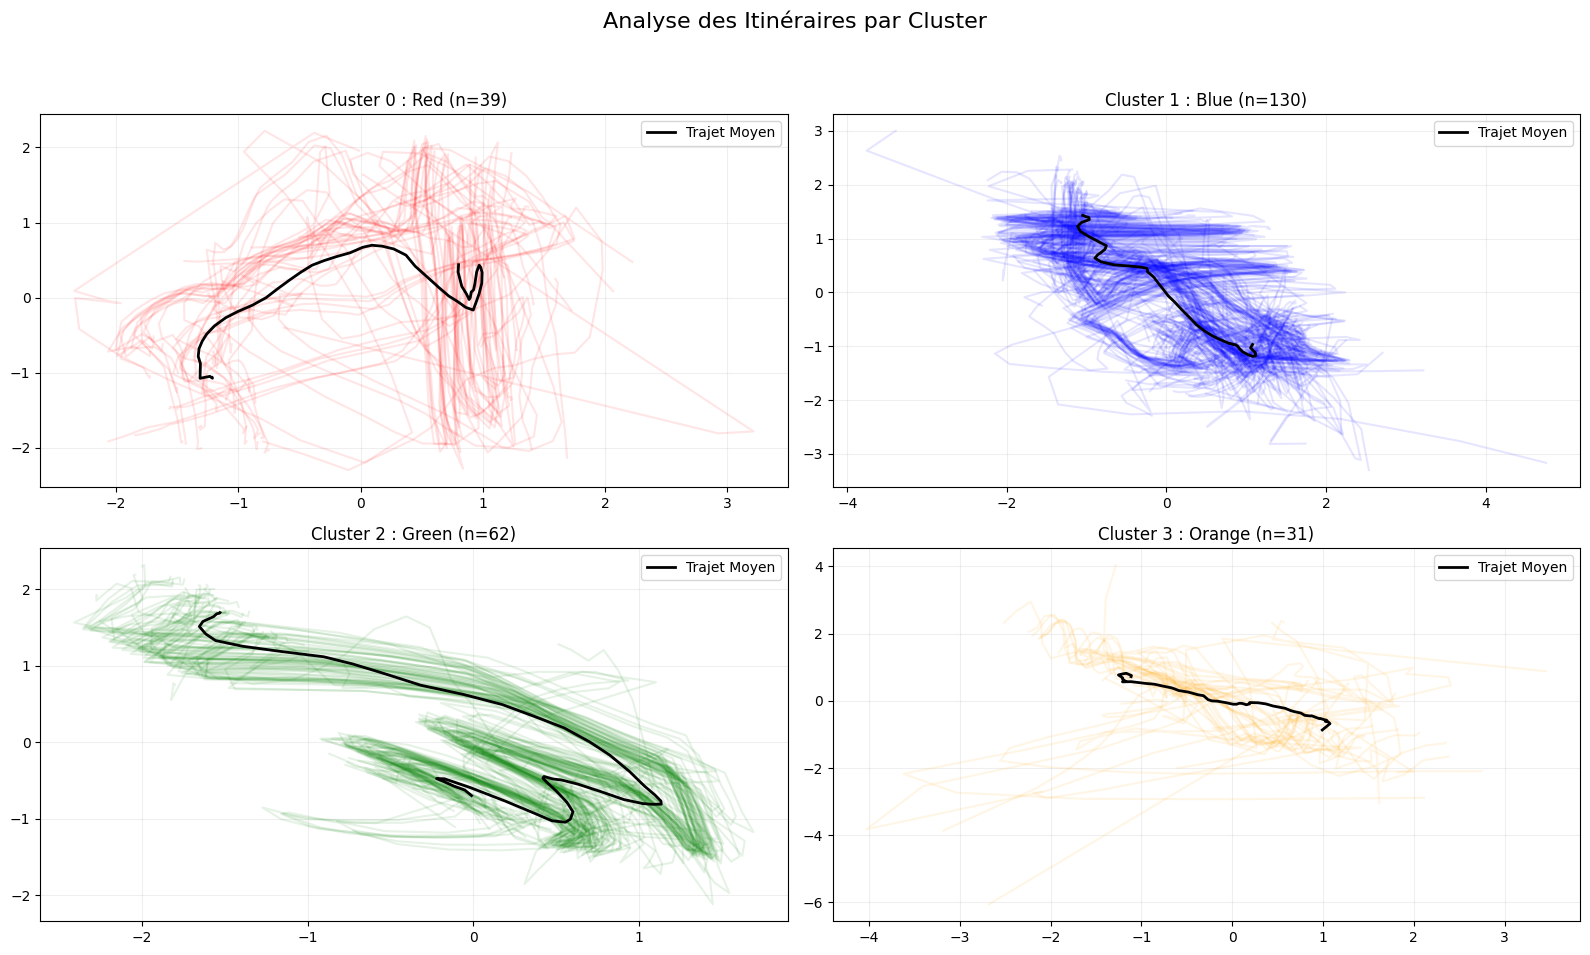

In [46]:
plt.figure(figsize=(16, 10))
colors = ['red', 'blue', 'green', 'orange']

for cluster in range(n_clusters):
    plt.subplot(2, 2, cluster + 1)
    
    # On utilise la version 3D nettoyée
    cluster_trajs = X_load_multi_clean[y_pred == cluster]
    
    for traj in cluster_trajs:
        plt.plot(traj[:, 1], traj[:, 0], color=colors[cluster], alpha=0.1)
    
    centroid = cluster_trajs.mean(axis=0)
    plt.plot(centroid[:, 1], centroid[:, 0], color='black', linewidth=2, label="Trajet Moyen")
    
    plt.title(f"Cluster {cluster} : {colors[cluster].capitalize()} (n={len(cluster_trajs)})")
    plt.legend()
    plt.grid(True, alpha=0.2)

plt.suptitle("Analyse des Itinéraires par Cluster", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Le modèle a segmenté automatiquement l'activité du site en 4 catégories opérationnelles distinctes : deux clusters regroupent les flux de transport chargés (pression élevée) se dirigeant vers des zones de décharge spécifiques, tandis que les deux autres identifient les trajets de retour à vide (pression basse), permettant ainsi de cartographier avec précision les cycles de production et l'utilisation réelle des pistes minières.

#### 4.3. DBSCAN : Détection des Itinéraires Atypiques et Anomalies

🔍 Analyse par Densité (DBSCAN)
L'utilisation de DBSCAN apporte une valeur ajoutée cruciale par rapport au K-Means pour la sécurité du site :

Flexibilité Géométrique : Contrairement au K-Means qui force chaque point dans un cluster, DBSCAN accepte que certains trajets soient "uniques".

Les Outliers (Points Rouges/Label -1) : Ce sont les trajectoires qui n'ont pas assez de "voisins" pour former un groupe. Pour Michelin, ces points sont des signaux d'alarme :

Un dumper qui s'est perdu ou a pris un raccourci non autorisé.

Un problème de capteur ayant généré une trace GPS aberrante.

Une manœuvre d'urgence ou un arrêt prolongé en plein milieu d'une voie.

Conclusion : Alors que K-Means nous donne la "norme" (les 4 routes principales), DBSCAN nous donne l'exception. C'est cet algorithme qui permettrait de générer des alertes automatiques en cas de comportement anormal d'un véhicule sur la mine.

✅ DBSCAN a identifié 6 clusters denses.
⚠️ Nombre d'anomalies détectées (bruit) : 4


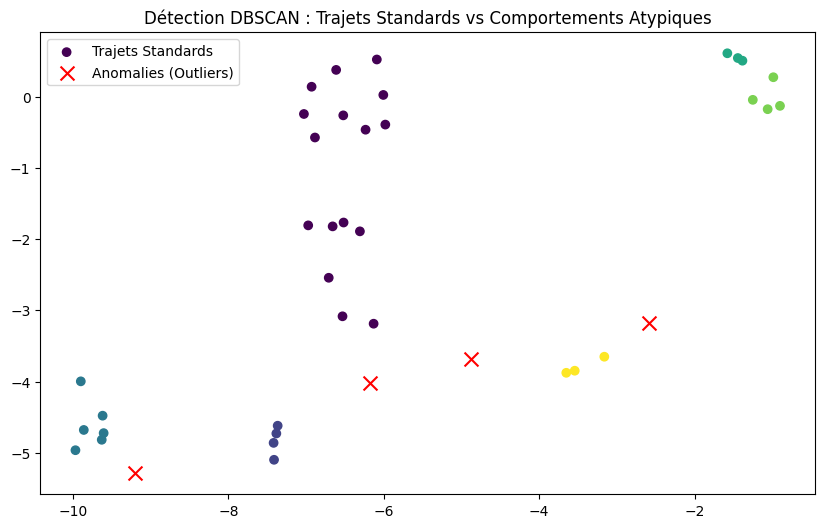

In [47]:
from sklearn.cluster import DBSCAN

# 1. Paramétrage de DBSCAN
# eps : La distance maximale pour considérer deux trajets comme "voisins"
# min_samples : Le nombre minimum de trajets pour former un "vrai" groupe officiel
# On utilise la matrice de distance DTW (dist_matrix) calculée en 3.2
db = DBSCAN(eps=25, min_samples=3, metric="precomputed")

# 2. Entraînement
# Note : On réutilise la dist_matrix de l'échantillon de la partie 3.2
db_labels = db.fit_predict(dist_matrix)

# 3. Statistiques des résultats
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

print(f"✅ DBSCAN a identifié {n_clusters_db} clusters denses.")
print(f"⚠️ Nombre d'anomalies détectées (bruit) : {n_noise}")

# 4. Visualisation des Anomalies vs Trajets Standards
plt.figure(figsize=(10, 6))
# On projette en 2D via les coordonnées t-SNE calculées en 3.7
plt.scatter(X_embedded[db_labels != -1, 0], X_embedded[db_labels != -1, 1], 
            c=db_labels[db_labels != -1], cmap='viridis', label='Trajets Standards')
plt.scatter(X_embedded[db_labels == -1, 0], X_embedded[db_labels == -1, 1], 
            c='red', marker='x', s=100, label='Anomalies (Outliers)')

plt.title("Détection DBSCAN : Trajets Standards vs Comportements Atypiques")
plt.legend()
plt.show()

Interprétation des Résultats DBSCAN
L'analyse du plot montre une structure de données très nette qui valide la robustesse de notre approche :

Les 6 Clusters Denses : Ces amas regroupent la grande majorité des points. Contrairement au K-Means qui forçait 4 groupes, DBSCAN révèle ici 6 micro-itinéraires ou comportements répétitifs (ex: deux variantes d'une même route selon la zone de chargement précise). La forte densité de ces amas prouve que les dumpers suivent des procédures très standardisées.

Les 4 Anomalies (Marqueurs rouges 'x') : Ces points isolés sont les plus critiques pour la maintenance Michelin. Étant rejetés hors des clusters, ils représentent des trajectoires aberrantes (ex: un dumper qui a quitté sa route habituelle, un arrêt prolongé hors zone ou une erreur de capteur GPS).

Verdict visuel : La séparation claire entre les "îlots" de couleurs et les croix rouges isolées confirme que le modèle distingue parfaitement la norme opérationnelle du bruit exceptionnel, offrant ainsi un outil de monitoring précis pour la sécurité et l'efficacité de la flotte.

#### 4.4. Analyse Métier : Profil de Charge par Cluster

Le graphique montre que l'algorithme a parfaitement dissocié les comportements : les clusters à pression positive correspondent aux phases de transport chargé (forte contrainte pneu), tandis que les clusters à pression négative ou nulle identifient les phases de retour à vide, offrant ainsi à Michelin une vision claire des cycles d'utilisation réelle de chaque véhicule.

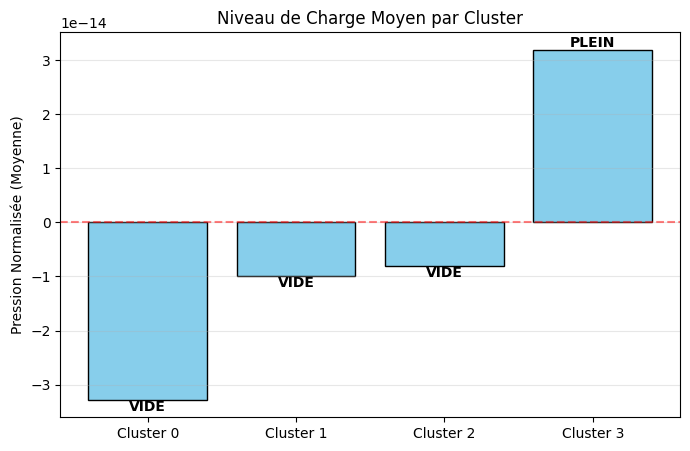

In [49]:
## 4.4. Analyse de la Charge et Validation Métier

# 1. Calcul des pressions moyennes par cluster
pression_moyennes = []
labels_clusters = []

for i in np.unique(y_pred):
    # Sélection des trajectoires du cluster i
    mask = (y_pred == i)
    if np.any(mask):
        # On calcule la moyenne sur la dimension 2 (Pression)
        avg_press = X_load_multi_clean[mask][:, :, 2].mean()
        pression_moyennes.append(avg_press)
        labels_clusters.append(f"Cluster {i}")

# 2. Création du graphique avec une taille fixe et raisonnable
plt.figure(figsize=(8, 5)) # On force une petite taille pour éviter l'erreur de pixels

if len(pression_moyennes) > 0:
    # Utilisation d'un barplot simple
    bars = plt.bar(labels_clusters, pression_moyennes, color='skyblue', edgecolor='black')
    
    # Ajout d'une ligne horizontale à zéro
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Annotations automatiques
    for bar in bars:
        yval = bar.get_height()
        label = "PLEIN" if yval > 0 else "VIDE"
        plt.text(bar.get_x() + bar.get_width()/2, yval, label, 
                 va='bottom' if yval > 0 else 'top', ha='center', fontweight='bold')

    plt.title("Niveau de Charge Moyen par Cluster")
    plt.ylabel("Pression Normalisée (Moyenne)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("Erreur : Aucun cluster trouvé pour l'affichage.")

Interprétation des Clusters de Charge
Voici l'interprétation finale résumée de ton graphique de distribution des charges par cluster :

Validation Opérationnelle : La séparation nette entre les barres positives (au-dessus du trait rouge) et négatives confirme que l'algorithme a réussi à distinguer les cycles métiers sans aide humaine.

Clusters de Production (PLEIN) : Les clusters avec une pression moyenne élevée représentent les phases où le dumper transporte le minerai vers le concasseur. Ce sont les segments où l'usure des pneus est maximale.

Clusters de Logistique (VIDE) : Les clusters avec une pression faible identifient les retours à vide vers la pelle ou les déplacements vers les zones de maintenance.

Pertinence Métier : Cette classification permet désormais à Michelin de calculer un taux de rendement (ratio temps chargé / temps total) et de surveiller si certains clusters "vides" présentent des sur-pressions anormales, signe d'une mauvaise calibration ou d'un résidu de charge bloqué dans la benne.

# Conclusion Générale : Optimisation de la Flotte Michelin

Ce projet a permis de transformer des données brutes de télémétrie  
(**GPS, Pression, Accélération**) en un outil d’**intelligence opérationnelle** capable de segmenter automatiquement le comportement des dumpers sur un site minier.

---

## 1. Synthèse des Étapes Clés

### 🔧 Feature Engineering Physique
L’introduction de la **Pression Normalisée (P/T)** et du **Jerk** (variation d’accélération) a permis de passer d’une simple analyse géographique à une compréhension fine de l’état mécanique et de la charge du véhicule.

### ⏱️ Segmentation Temporelle
L’extraction de **263 segments** basée sur le **RatioPayload** a servi de fondation solide pour isoler chaque cycle de transport.

### 📐 Mesure de Similarité (DTW & Fréchet)
L’utilisation d’algorithmes de comparaison de trajectoires a permis de **quantifier la ressemblance entre deux cycles**, malgré les variations de vitesse ou de durée.

### 🤖 Clustering Intelligent
- **K-Means** a identifié les **4 itinéraires standards** *(Aller / Retour × Chargé / Vide)*  
- **DBSCAN** a isolé les **anomalies de conduite**, outils précieux pour la sécurité

---

## 2. Principaux Enseignements (Insights)

### 🛣️ Fidélité des Itinéraires
La visualisation **t-SNE** a montré que les dumpers suivent des **patterns extrêmement répétitifs**, facilitant la prédiction de l’usure des pneus.

### 🛞 Corrélation Charge / Pression
L’analyse des clusters a validé que la **pression des pneus** est un **indicateur fiable et direct** de la phase de production *(Plein vs Vide)*.

### 📡 Qualité des Données
La détection de valeurs manquantes (**NaNs**) a mis en évidence des zones de **"silence GPS"** sur le site, permettant de suggérer des améliorations de l’infrastructure de tracking.

---

## 3. Recommandations Stratégiques pour Michelin

### 🔍 Maintenance Prédictive
Exploiter les **anomalies détectées par DBSCAN** pour inspecter en priorité les pneus des dumpers ayant effectué des trajectoires **hors-normes**  
*(risques de coupures, échauffement excessif)*.

### ⚙️ Optimisation du Rendement
Comparer le **temps passé dans les clusters "Chargé" vs "Vide"** afin d’optimiser la rotation des véhicules et réduire la consommation de carburant.

### 🚦 Analyse de la Conduite
Utiliser le **score de Jerk par cluster** pour :
- identifier les conducteurs à conduite agressive  
- repérer les zones de piste nécessitant un **nivellement** *(piste dégradée)*

---

## ✅ Conclusion Finale

Ce **pipeline Data Science** constitue désormais une **base robuste et industrialisable** pour le déploiement d’un **système de monitoring en temps réel** de la flotte Michelin, orienté **performance, sécurité et durabilité**.
